<h1 align='center'> Sentiment Analysis using Word2vec & LSTM

In [1]:
import numpy as np
import pandas as pd

#Preprocessing libraries
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from contractions import CONTRACTION_MAP #Importing contractions script
import unicodedata
import re

#Vectorizer library.
from keras.preprocessing.text import text_to_word_sequence,Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer, HashingVectorizer

#evaluation matrices library
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score

#LSTM Model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.model_selection import train_test_split

#Word2Vec
from gensim.models import KeyedVectors
import gensim
import os

#visulaization:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


In [2]:
#Read .csv file
filename = 'Twitter_Data.csv'
analysis_df = pd.read_csv(filename,encoding='latin1',usecols=['text','sentiment'])

In [3]:
analysis_df.head()

,text,sentiment
0,when modi promised âminimum government maxim...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [4]:
# convert the sentiments to numeric data.
def ConvertSentiments(_sentiment):
    cvt_sentiment = 0
    if _sentiment == 1:
        cvt_sentiment = 2
    elif _sentiment == 0:
        cvt_sentiment = 1
    else:
        cvt_sentiment = 0
        
    return cvt_sentiment

In [5]:
analysis_df['C_Sentiment'] = analysis_df.sentiment.apply(ConvertSentiments)

In [6]:
print(analysis_df.shape)
analysis_df.head()

(162951, 3)


,text,sentiment,C_Sentiment
0,when modi promised âminimum government maxim...,-1.0,0
1,talk all the nonsense and continue all the dra...,0.0,1
2,what did just say vote for modi welcome bjp t...,1.0,2
3,asking his supporters prefix chowkidar their n...,1.0,2
4,answer who among these the most powerful world...,1.0,2


Text(0.5, 0, 'Sentiment Type')

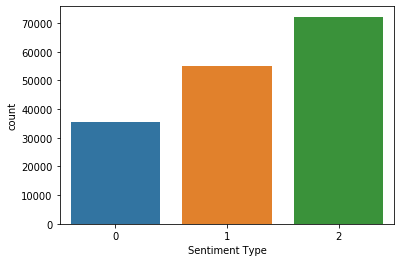

In [7]:
sns.countplot(analysis_df.C_Sentiment)
plt.xlabel('Sentiment Type')

In [8]:
#converting tweets into lower:
analysis_df['text'] = [str(tweets).strip().lower() for tweets in analysis_df['text']]

In [9]:
#Text Preprocessing
#Contractions:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


#Scrub word removal:
def scrub_words(text):
    #Replace \xao characters in text
    text = re.sub('\xa0', ' ', text)
    
    #Replace non ascii / not words and digits
    text = re.sub("(\\W|\\d)",' ',text)
    
    #Replace new line characters and following text untill space
    text = re.sub('\n(\w*?)[\s]', '', text)
    
    #Remove html markup
    text = re.sub("<.*?>", ' ', text)
    return text

#Creating function object to convert ASCII character
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [10]:
analysis_df['text'] = analysis_df.text.apply(expand_contractions)

In [11]:
analysis_df['text'] = analysis_df.text.apply(scrub_words)

In [12]:
analysis_df['text'] = analysis_df.text.apply(remove_accented_chars)

In [13]:
analysis_df.head()

,text,sentiment,C_Sentiment
0,when modi promised a minimum government maxim...,-1.0,0
1,talk all the nonsense and continue all the dra...,0.0,1
2,what did just say vote for modi welcome bjp t...,1.0,2
3,asking his supporters prefix chowkidar their n...,1.0,2
4,answer who among these the most powerful world...,1.0,2


In [14]:
# stopwords:
stopWords = stopwords.words('english')
#add extra stop word
extra_stopWords = ['na','rt','http']
stopWords.extend(extra_stopWords)

In [15]:
print(stopWords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### Tokenization and Stop word removal. (Stemming or Lemmatization)

In [16]:
# Tokenization and Stop word removal.
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def Tokenizer_SWR_SL(_text, isLemamtize = False):
    tweets = text_to_word_sequence(_text)
    if isLemamtize:
        tweets = [lemmatizer.lemmatize(word) for word in tweets if not word in stopWords]
    else:
        tweets = [stemmer.stem(word) for word in tweets if not word in stopWords]    
    tweets = ' '.join(tweets)
    
    return tweets

In [17]:
analysis_df['text'] = analysis_df.text.apply(Tokenizer_SWR_SL,True)
analysis_df.head()

,text,sentiment,C_Sentiment
0,modi promis minimum govern maximum governancea...,-1.0,0
1,talk nonsens continu drama vote modi,0.0,1
2,say vote modi welcom bjp told rahul main campa...,1.0,2
3,ask support prefix chowkidar name modi great s...,1.0,2
4,answer among power world leader today trump pu...,1.0,2


In [18]:
#Word tokenizing the tweets so that it can be proessed further.
tokenized_tweet  = analysis_df.text.apply(lambda x: text_to_word_sequence(x))
print(tokenized_tweet [0:5])

0    [modi, promis, minimum, govern, maximum, gover...
1          [talk, nonsens, continu, drama, vote, modi]
2    [say, vote, modi, welcom, bjp, told, rahul, ma...
3    [ask, support, prefix, chowkidar, name, modi, ...
4    [answer, among, power, world, leader, today, t...
Name: text, dtype: object


In [19]:
# find the max length within the tweets.
def FindMaxLength(_tweet_seq):
    tweet_length = []
    for tweet in _tweet_seq:
        tweet_length.append(len(tweet))
    return max(tweet_length)     

In [20]:
#Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_tweet)
tweet_seq = tokenizer.texts_to_sequences(tokenized_tweet)

In [21]:
max_length = FindMaxLength(tweet_seq)

In [22]:
#Assigning unique int values for each vocabulary
word_index = tokenizer.word_index
print(f"unique tokens - {len(word_index)}")
vocab_size = len(tokenizer.word_index) + 1
print(f'vocab_size - {vocab_size}')

# Padding the tweets with max tweet length. post padding is done.
# X Attribute:
lines_pad = pad_sequences(tweet_seq, maxlen=max_length, padding='post')
# Target Attribute:
category =  analysis_df['C_Sentiment'].values

#Example for padded tweet.
print(lines_pad.shape)
lines_pad[0]

unique tokens - 84521
vocab_size - 84522
(162951, 59)


array([    1,    54,   699,    27,  1533, 17302,   271,   896,  1093,
          55,  1207,   115,    28,    14,    21,   995,   115,   265,
        3011,  2652,  1106,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0])

#### Train & Test split

In [23]:
#Manual way of dummification example.
testCat = [0,1,2,2,1,1,1,0]
np.eye(3)[testCat]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [24]:
test_split = 0.3
validation_split = 0.5
random_st = 123
# Shuffling data.
indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices] # Shuffled form of X attributes
category = category[indices] # Shuffled form of target variables

n_values = max(category) + 1
# Dummifying the target attribute
Y = np.eye(n_values)[category]

#The data is split into Train=70% & Test=30%.
X_train, X_test, y_train, y_test = train_test_split(lines_pad, Y , test_size=test_split, random_state=random_st)
#The Test data is again split into Test=50% & Validation=50%.
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test , test_size=validation_split, random_state=random_st)

In [25]:
print(f'Shape of X_train :{X_train.shape}')
print(f'Shape of y_train :{y_train.shape}\n')

print(f'Shape of X_test :{X_test.shape}')
print(f'Shape of y_test :{y_test.shape}\n')

print(f'Shape of X_val :{X_val.shape}')
print(f'Shape of y_val :{y_val.shape}')

Shape of X_train :(114065, 59)
Shape of y_train :(114065, 3)

Shape of X_test :(24443, 59)
Shape of y_test :(24443, 3)

Shape of X_val :(24443, 59)
Shape of y_val :(24443, 3)


## Word2Vec

In [26]:
#Loading Word2vec pretrained model.
embedding_dim = 300
word2vec_dir = "D:\Word2Vec\PretrainedModel"
word2vec_model = KeyedVectors.load_word2vec_format(os.path.join(word2vec_dir,'GoogleNews-vectors-negative300.bin'), binary=True)

In [27]:
#Creating embedding matrix
#creating a empty matrix with rows of (len(word_index)+ 1) and columns of embedding_dim(300)
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, _id in word_index.items():
    #Add embedding vectors od vocabulary that is present in Word2vec
    if word in word2vec_model: 
        embedding_vector = word2vec_model[word]
        embedding_matrix[_id] = embedding_vector

In [28]:
#Creating embedding layer.
#Setting trainable to false since we are using vec from Word2Vec
embedding_layer = Embedding(len(word_index) + 1,embedding_dim,weights=[embedding_matrix],
                            input_length=max_length,trainable=False)

In [29]:
#LSTM Model building
lstm_word2vec_model = Sequential()
lstm_word2vec_model.add(embedding_layer)
lstm_word2vec_model.add(LSTM(units=32,  dropout=0.2, recurrent_dropout=0.25))
#model with 3 neurons in the output layer.
lstm_word2vec_model.add(Dense(3, activation='softmax'))

lstm_word2vec_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(lstm_word2vec_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 59, 300)           25356600  
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                42624     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 25,399,323
Trainable params: 42,723
Non-trainable params: 25,356,600
_________________________________________________________________
None


In [30]:
# Checkpoint for early stopping and saving the model
checkpoint = ModelCheckpoint('LSTM-SentimentModel.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='auto')

In [31]:
lstm_word2vec = lstm_word2vec_model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test), callbacks=[checkpoint], verbose=1)

Train on 114065 samples, validate on 24443 samples
Epoch 1/10
114065/114065 [==============================] - 109s 960us/step - loss: 0.8758 - accuracy: 0.5972 - val_loss: 0.7711 - val_accuracy: 0.6685

Epoch 00001: val_accuracy improved from -inf to 0.66849, saving model to LSTM-SentimentModel.h5
Epoch 2/10
114065/114065 [==============================] - 109s 954us/step - loss: 0.7271 - accuracy: 0.6918 - val_loss: 0.6655 - val_accuracy: 0.7263

Epoch 00002: val_accuracy improved from 0.66849 to 0.72634, saving model to LSTM-SentimentModel.h5
Epoch 3/10
114065/114065 [==============================] - 109s 952us/step - loss: 0.6759 - accuracy: 0.7192 - val_loss: 0.6285 - val_accuracy: 0.7445

Epoch 00003: val_accuracy improved from 0.72634 to 0.74451, saving model to LSTM-SentimentModel.h5
Epoch 4/10
114065/114065 [==============================] - 109s 955us/step - loss: 0.6505 - accuracy: 0.7318 - val_loss: 0.6070 - val_accuracy: 0.7576

Epoch 00004: val_accuracy improved from 0.7

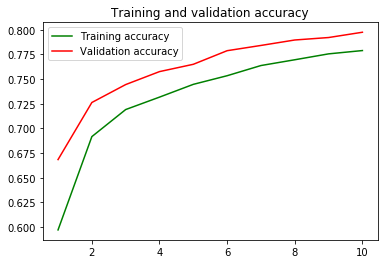

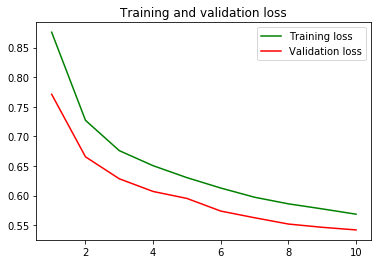

In [32]:
# Plot results
import matplotlib.pyplot as plt

acc = lstm_word2vec.history['accuracy']
val_acc = lstm_word2vec.history['val_accuracy']
loss = lstm_word2vec.history['loss']
val_loss = lstm_word2vec.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [33]:
val_pred = lstm_word2vec_model.predict_classes(X_val)

In [34]:
val_actual = [np.argmax(data) for data in y_val]

In [37]:
print("F! score for Validation : ",f1_score(val_actual,val_pred,average='macro'))

F! score for Validation :  0.7785975348371103


In [38]:
print("Accuracy for validation data : ", accuracy_score(val_actual,val_pred))

Accuracy for validation data :  0.7971607413165324
